# Assignment 3

The goal of assignment 3 is for your learn TD-IDF, cosine similarity, and embedding.

Here are four types of data (i.e. four categories of lyrics)
* https://slpcourse.github.io/materials/lyrics/country.txt
* https://slpcourse.github.io/materials/lyrics/pop.txt
* https://slpcourse.github.io/materials/lyrics/rap.txt
* https://slpcourse.github.io/materials/lyrics/rock.txt

Each song is segmented by `<SONG_BOUNDARY>`

## Task 1: TF-IDF [60 marks]

Implement the TF-IDF algorithm. You need to write your own compute_tf, and compute_idf functions.

In [1]:
# impement your TF-IDF algorithms here
import string
import math
from collections import defaultdict
import numpy as np
from scipy.sparse import csr_matrix

####
#despite regular TF-IDF, I add punctuations and stop words removal, convert all words into lowercase.
#also, I filter out low frequency word based on document frequency to help reduce noise.
####

punctuation = set(string.punctuation)
stop_words = set("a,an,and,are,as,at,be,but,by,for,if,in,into,is,it,no,not,of,on,or,such,that,the,their,then,there,these,they,this,to,was,will,with".split(","))

# Step 1: Tokenization and punctuation + stop words Removal
def tokenize_and_remove_punctuation(document, punctuation, stop_words):
  return [word for word in document.lower().split() if word not in punctuation.union(stop_words)]

# Step 2: Calculate TF, IDF，TF-IDF
def compute_tf(documents, punctuation, stop_words, global_tf, min_freq=2):
  tf = defaultdict(dict)
  for i, doc in enumerate(documents):
    words = tokenize_and_remove_punctuation(doc, punctuation, stop_words)
    filtered_words = [word for word in words if global_tf[word] >= min_freq]
    for word in filtered_words:
      tf[i][word] = tf[i].get(word, 0) + 1
  return tf

def compute_idf(documents, punctuation, stop_words, global_tf, min_freq=2):
  df = defaultdict(int)
  for i, doc in enumerate(documents):
    words = tokenize_and_remove_punctuation(doc, punctuation, stop_words)
    filtered_words = [word for word in words if global_tf[word] >= min_freq]
    for word in set(filtered_words):
      df[word] += 1

  idf = {word: math.log(len(documents) / (df[word])) for word in df if df[word] >= min_freq}
  return idf

def compute_tf_idf(tf, idf):
  tf_idf = defaultdict(dict)
  for doc_id, word_counts in tf.items():
    doc_length = sum(word_counts.values())
    for word, count in word_counts.items():
      if word in idf:
        tf_idf[doc_id][word] = (count / doc_length) * idf[word] # Normalize
        #tf_idf[doc_id][word] = math.log((count + 1)) * idf[word] # Another method which taught in class

  return tf_idf

def compute_global_term_frequencies(documents, punctuation, stop_words):
  global_tf = defaultdict(int)
  for doc in documents:
    words = tokenize_and_remove_punctuation(doc, punctuation, stop_words)
    for word in set(words):
      global_tf[word] += 1
  return global_tf

def compute_terms_by_frequency(tf_idf, global_tf, min_freq=2):
  filtered_tf_idf = defaultdict(dict)
  for doc_id, word_scores in tf_idf.items():
    for word, score in word_scores.items():
      if global_tf[word] >= min_freq:
        filtered_tf_idf[doc_id][word] = score
  return filtered_tf_idf

def compute_tf_idf_with_filtering(documents, punctuation, stop_words, min_freq=2):
  global_tf = compute_global_term_frequencies(documents, punctuation, stop_words)

  tf = compute_tf(documents, punctuation, stop_words, global_tf, min_freq)
  idf = compute_idf(documents, punctuation, stop_words, global_tf, min_freq)
  tf_idf = compute_tf_idf(tf, idf)

  filtered_tf_idf = compute_terms_by_frequency(tf_idf, global_tf, min_freq)

  return filtered_tf_idf, idf

# Step 3: Convert to Sparse Matrix and Normalize
def normalize(matrix, norm='l2', axis=1):
  norms = np.sqrt(matrix.power(2).sum(axis=axis))
  norms[norms == 0] = 1
  matrix = matrix.multiply(1 / norms.reshape((-1, 1)))
  return matrix

def tf_idf_to_sparse_matrix(tf_idf, idf, documents):
  words_list = list(idf.keys())
  words_index = {word: i for i, word in enumerate(words_list)}
  rows, cols, data = [], [], []
  for doc_id, word_scores in tf_idf.items():
    for word, score in word_scores.items():
      rows.append(doc_id)
      cols.append(words_index[word])
      data.append(score)
  X = csr_matrix((data, (rows, cols)), shape=(len(documents), len(idf)))
  X = normalize(X, norm='l2', axis=1)
  return X

## Task 2: Kmeans clustering [40 marks]

Perform kmeans clustering with the TF-IDF weights. You need to initialize the kmeans centroid in two different ways: random initialization, and smart initialization where you initialize the centroid with a vector from each category.

Here are your tasks

*   Visualize the clustering results from random initialization. each cluster need to have its own color, and highlight the centroid
*   Visualize the clustering results from smart initialization. each cluster need to have its own color, and highlight the centroid
*   Calculate the cosine similarity of the kmeans centroid from smart initialization. Present your result in a table
*   Discuss the difference and your observation

You may use scikit-learn for kmeans clustering and t-SNE visualization



In [2]:
import requests
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

urls = {"country": "https://slpcourse.github.io/materials/lyrics/country.txt",
    "pop": "https://slpcourse.github.io/materials/lyrics/pop.txt",
    "rap": "https://slpcourse.github.io/materials/lyrics/rap.txt",
    "rock": "https://slpcourse.github.io/materials/lyrics/rock.txt"}

# Function to read lyric
def read_lyrics(url):
  response = requests.get(url)
  songs = response.text.split('<SONG_BOUNDARY>')
  return songs

# Read and preprocess the data
all_lyrics = []
labels = []  # To keep track of genres for smart initialization
for genre, path in urls.items():
  songs = read_lyrics(path)
  all_lyrics.extend(songs)
  labels.extend([genre] * len(songs))

# Get TF-IDF weights
filtered_tf_idf, idf = compute_tf_idf_with_filtering(all_lyrics, punctuation, stop_words, min_freq=2)
X = tf_idf_to_sparse_matrix(filtered_tf_idf, idf, all_lyrics)
X = X.tocsr()

In [3]:
# Visualizing clusters using t-SNE
def visualize_clusters(X, kmeans, title):
  tsne = TSNE(n_components=2, random_state=42)
  X_tsne = tsne.fit_transform(X.toarray())
  plt.figure(figsize=(12, 8))
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis')

  for i in range(kmeans.n_clusters):
    points_idx = np.where(kmeans.labels_ == i)[0]
    centroid_tsne = np.mean(X_tsne[points_idx], axis=0)
    plt.scatter(centroid_tsne[0], centroid_tsne[1], c='red', s=200, alpha=0.5, marker='X')

  plt.title(title)
  plt.show()

#1. random initialization

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


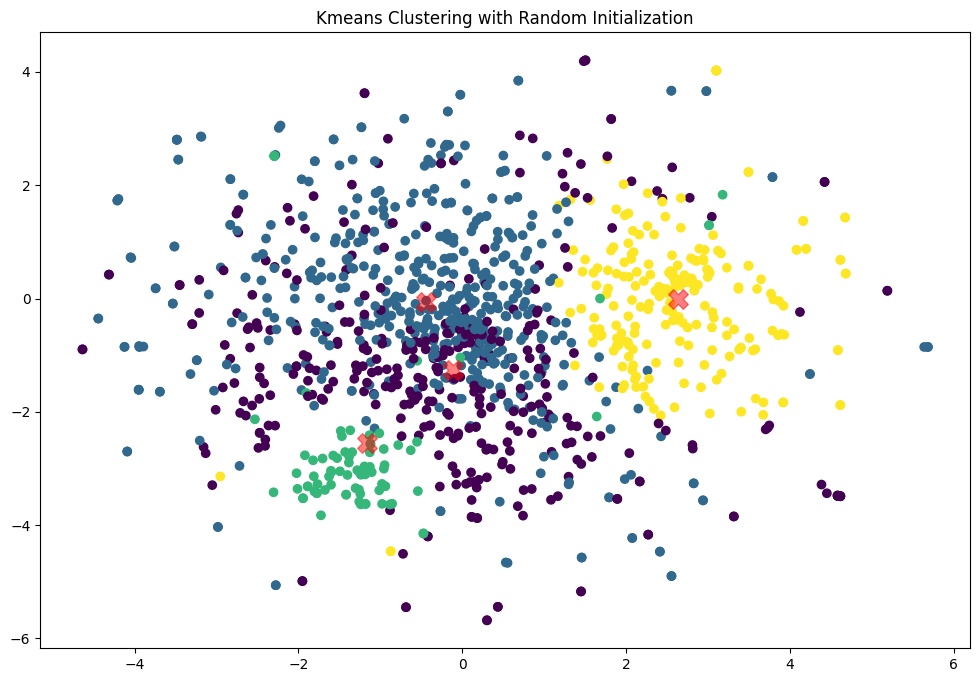

In [4]:
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42).fit(X)

visualize_clusters(X, kmeans_random, 'Kmeans Clustering with Random Initialization')

# 2. smart initialization

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


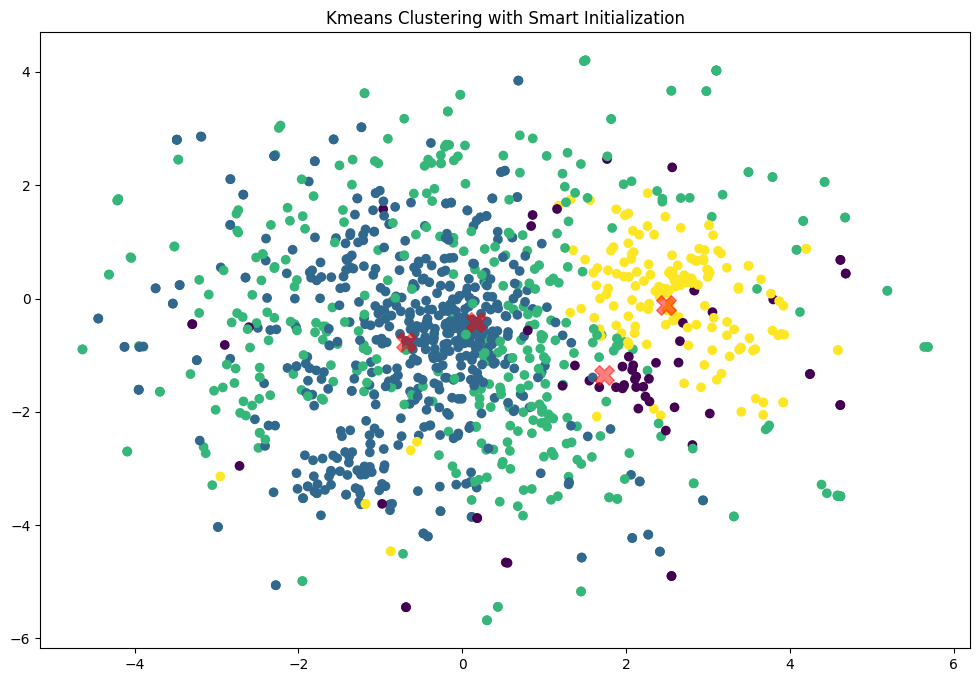

In [5]:
# 2. smart initialization
smart_init_indices = [labels.index(genre) for genre in set(labels)]
smart_init_matrix = X[smart_init_indices]
kmeans_smart = KMeans(n_clusters=4, init=smart_init_matrix.toarray()).fit(X)

visualize_clusters(X, kmeans_smart, 'Kmeans Clustering with Smart Initialization')

#3. Cosine Similarity

In [6]:
def cosine_similarity(vector1, vector2):
  dot_product = np.dot(vector1, vector2)
  norm_vector1 = np.linalg.norm(vector1)
  norm_vector2 = np.linalg.norm(vector2)
  return dot_product / (norm_vector1 * norm_vector2)

centroids = kmeans_smart.cluster_centers_

# Calculate the cosine similarity matrix
n_centroids = centroids.shape[0]
cosine_sim_matrix = np.zeros((n_centroids, n_centroids))

for i in range(n_centroids):
  for j in range(n_centroids):
    cosine_sim_matrix[i, j] = cosine_similarity(centroids[i], centroids[j])

# Presenting the results in a table
centroid_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

cosine_sim_tb = pd.DataFrame(cosine_sim_matrix, index=centroid_labels, columns=centroid_labels)

print("Cosine Similarity Table:")
print(cosine_sim_tb)

Cosine Similarity Table:
           Cluster 1  Cluster 2  Cluster 3  Cluster 4
Cluster 1   1.000000   0.480699   0.494724   0.495778
Cluster 2   0.480699   1.000000   0.797637   0.517904
Cluster 3   0.494724   0.797637   1.000000   0.543997
Cluster 4   0.495778   0.517904   0.543997   1.000000


## 4. discuss difference and observation

In [7]:
print("Difference:")
print("Centroids in samrt initialization are more close to each other than Centroids in random initialization.")
print("Random initialization method makes each cluster more balanced and dispersed from each other, with clearer demarcation lines, comparing to the smart initialization.")
print("Observation:")
print("Removing punctuation, stop words and low-frequence words result in better cosine similarity and better clustering.")
print("Different ways to normalize TF and IDF will influence cosine similarity: ")
print("I use tf_idf[doc_id][word] = (count / doc_length) * idf[word] to calculate TF-IDF in my visualization, and random initialization is better than smart initialization.")
print("But if I use tf_idf[doc_id][word] = math.log((count + 1)) * idf[word] to get TF-IDF, smart initialization is better than random initialization.")
print("Besides, choosing a good number of min-global-frequence is important.")

Difference:
Centroids in samrt initialization are more close to each other than Centroids in random initialization.
Random initialization method makes each cluster more balanced and dispersed from each other, with clearer demarcation lines, comparing to the smart initialization.
Observation:
Removing punctuation, stop words and low-frequence words result in better cosine similarity and better clustering.
Different ways to normalize TF and IDF will influence cosine similarity: 
I use tf_idf[doc_id][word] = (count / doc_length) * idf[word] to calculate TF-IDF in my visualization, and random initialization is better than smart initialization.
But if I use tf_idf[doc_id][word] = math.log((count + 1)) * idf[word] to get TF-IDF, smart initialization is better than random initialization.
Besides, choosing a good number of min-global-frequence is important.
